## Workflow

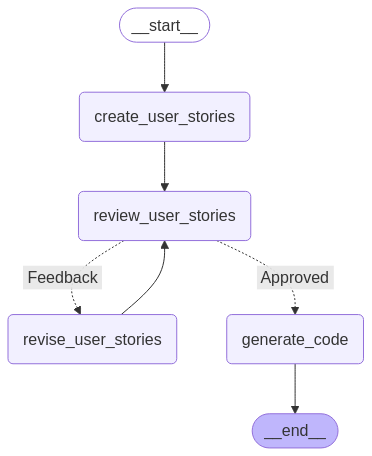

In [ ]:
from dotenv import load_dotenv
from typing import List
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Load env vars
load_dotenv()

# Initialize Llama3 model
llm = ChatGroq(model="llama3-70b-8192")

class UserStory(BaseModel):
    title: str = Field(
        description="Title of the user story summarizing the functionality."
    )
    description: str = Field(
        description="Detailed user story following the format: 'As a [user], I want to [action] so that [benefit]'."
    )
    acceptance_criteria: List[str] = Field(
        description="List of acceptance criteria that define when this story is complete."
    )


class UserStories(BaseModel):
    stories: List[UserStory] = Field(
        default_factory=list, description="List of generated user stories."
    )
    
# UserStory schema for structured output
user_story_evaluator = llm.with_structured_output(UserStories)

class State(TypedDict):
    user_stories_review_status: str


def create_user_stories(state: State):
    pass

def review_user_stories(state: State):
    pass

def revise_user_stories(state: State):
    pass

def generate_code(state: State):
    pass

def route_review_user_stories(state: State):
    if state["user_stories_review_status"] == "approved":
        return "Approved"
    elif state["user_stories_review_status"] == "feedback":
        return "Feedback"

# Workflow Builder
workflow_builder = StateGraph(State)

# Add nodes
workflow_builder.add_node("create_user_stories", create_user_stories)
workflow_builder.add_node("review_user_stories", review_user_stories)
workflow_builder.add_node("revise_user_stories", revise_user_stories)
workflow_builder.add_node("generate_code", generate_code)

# Add edges to connect nodes
workflow_builder.add_edge(START, "create_user_stories")
workflow_builder.add_edge("create_user_stories", "review_user_stories")
workflow_builder.add_conditional_edges(
    "review_user_stories",
    route_review_user_stories,
    {
        "Approved": "generate_code",
        "Feedback": "revise_user_stories"
    }
)
workflow_builder.add_edge("revise_user_stories", "review_user_stories")
workflow_builder.add_edge("generate_code", END)

# Compile workflow builder
workflow = workflow_builder.compile()

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
from dotenv import load_dotenv
from typing import List, Dict, Any
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Load env vars
load_dotenv()

# Initialize Llama3 model
llm = ChatGroq(model="llama3-70b-8192")

class UserStory(BaseModel):
    title: str = Field(
        description="Title of the user story summarizing the functionality."
    )
    description: str = Field(
        description="Detailed user story following the format: 'As a [user], I want to [action] so that [benefit]'."
    )
    acceptance_criteria: List[str] = Field(
        description="List of acceptance criteria that define when this story is complete."
    )


class UserStories(BaseModel):
    stories: List[UserStory] = Field(
        default_factory=list, description="List of generated user stories."
    )

# UserStory schema for structured output
user_story_evaluator = llm.with_structured_output(UserStories)

class State(TypedDict):
    user_stories: UserStories
    user_stories_review_status: str
    revised_stories: UserStories  # Add revised_stories to the state

def create_user_stories(state: State) -> Dict[str, Any]:
    """Generates user stories using the LLM."""
    prompt = "Create 3 user stories for an e-commerce platform."  # Example prompt
    result = user_story_evaluator.invoke(prompt)
    return {"user_stories": result}

def review_user_stories(state: State) -> Dict[str, Any]:
    """Presents user stories to a human for review and gathers feedback."""

    user_stories: UserStories = state.get("user_stories")  # Retrieve from state

    if not user_stories:
        return {"user_stories_review_status": "feedback", "revised_stories": None}

    print("\n*** User Stories for Review ***\n")
    for i, story in enumerate(user_stories.stories):
        print(f"Story {i+1}:")
        print(f"  Title: {story.title}")
        print(f"  Description: {story.description}")
        print("  Acceptance Criteria:")
        for criterion in story.acceptance_criteria:
            print(f"    - {criterion}")
        print("\n")

    review_status = input("Approve or Feedback? (approve/feedback): ").strip().lower()

    if review_status == "approve":
        return {"user_stories_review_status": "approved", "revised_stories": None}
    elif review_status == "feedback":
        # Get feedback (example: ask for revised stories)
        # In a real app, you'd have a more structured way to get revisions
        revised_stories_json = input("Enter revised user stories as JSON (or type 'same' to keep the same): ")
        if revised_stories_json.lower() == "same":
            revised_stories = user_stories
        else:
            try:
                revised_stories = UserStories.parse_raw(revised_stories_json)
            except Exception as e:
                print(f"Error parsing JSON: {e}")
                revised_stories = user_stories # Keep the original if parsing fails

        return {"user_stories_review_status": "feedback", "revised_stories": revised_stories}
    else:
        print("Invalid input.  Assuming feedback is needed.")
        return {"user_stories_review_status": "feedback", "revised_stories": user_stories} # Treat invalid input as feedback

def revise_user_stories(state: State) -> Dict[str, Any]:
    """Applies human feedback to revise the user stories."""
    revised_stories = state.get("revised_stories")

    if revised_stories:
        return {"user_stories": revised_stories}  # Update the user_stories in the state
    else:
        print("No revised stories found. Keeping the original ones.")
        return {"user_stories": state.get("user_stories")} # Keep the original

def generate_code(state: State) -> Dict[str, Any]:
    """Generates code based on the user stories."""
    user_stories = state.get("user_stories")
    if not user_stories:
        return {"code": "No user stories to generate code from."}

    # Simple example:  Just concatenate the descriptions
    code = "\n".join([story.description for story in user_stories.stories])
    return {"code": code}

def route_review_user_stories(state: State):
    if state["user_stories_review_status"] == "approved":
        return "Approved"
    elif state["user_stories_review_status"] == "feedback":
        return "Feedback"
    else:
        return "Feedback" # Default to feedback if status is unexpected

# Workflow Builder
workflow_builder = StateGraph(State)

# Add nodes
workflow_builder.add_node("create_user_stories", create_user_stories)
workflow_builder.add_node("review_user_stories", review_user_stories)
workflow_builder.add_node("revise_user_stories", revise_user_stories)
workflow_builder.add_node("generate_code", generate_code)

# Add edges to connect nodes
workflow_builder.add_edge(START, "create_user_stories")
workflow_builder.add_edge("create_user_stories", "review_user_stories")
workflow_builder.add_conditional_edges(
    "review_user_stories",
    route_review_user_stories,
    {
        "Approved": "generate_code",
        "Feedback": "revise_user_stories"
    }
)
workflow_builder.add_edge("revise_user_stories", "review_user_stories")
workflow_builder.add_edge("generate_code", END)

# Compile workflow builder
workflow = workflow_builder.compile()

# Initial State
inputs = {"user_stories_review_status": "feedback", "revised_stories": None, "user_stories": None}

# Run the workflow
result = workflow.invoke(inputs)

print("\n*** Workflow Result ***\n")
print(result)

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    pass



*** User Stories for Review ***

Story 1:
  Title: Search for products
  Description: As a customer, I want to search for products by keyword, category, or brand so that I can quickly find what I'm looking for.
  Acceptance Criteria:
    - The search bar is visible on every page.
    - The search results page displays relevant products.
    - The search results page allows filtering by price, brand, and category.


Story 2:
  Title: View product details
  Description: As a customer, I want to view detailed product information, including images, descriptions, and reviews so that I can make informed purchasing decisions.
  Acceptance Criteria:
    - Product details page displays product images.
    - Product details page displays product description.
    - Product details page displays customer reviews.


Story 3:
  Title: Checkout securely
  Description: As a customer, I want to securely checkout with various payment options so that I can complete my purchase quickly and safely.
  Acce